In [1]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion


In [2]:
df = pd.read_csv('../goodreads_train.csv')

In [3]:
df.columns

Index(['user_id', 'book_id', 'review_id', 'rating', 'review_text',
       'date_added', 'date_updated', 'read_at', 'started_at', 'n_votes',
       'n_comments'],
      dtype='object')

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
df['review_text_new'] = df['review_text'].astype('U')
#X = df[['review_text_new','n_votes']]
X = df['review_text_new']
y = df['rating'].astype('U')
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, stratify = y)

In [5]:
%%time
#https://towardsdatascience.com/featureunion-columntransformer-pipeline-for-preprocessing-text-data-9dcb233dbcb6

class CharacterCounter(BaseEstimator, TransformerMixin):
    """Count the number of characters in a document."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        n_characters = X.str.len()
        return n_characters.values.reshape(-1,1) # 2D array
    
class TokenCounter(BaseEstimator, TransformerMixin):
    """Count the number of tokens in a document."""
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        self.tokeniser = RegexpTokenizer(r'[A-Za-z]+')
        return self
    
    def transform(self, X):
        n_tokens = X.apply(lambda document: len(self.tokeniser.tokenize(document)))
        return n_tokens.values.reshape(-1,1) # 2D array

# Build a FeatureUnion
text = 'review_text_new'

vectoriser = TfidfVectorizer(lowercase = True,stop_words = 'english',analyzer = 'word',max_df=.2)
character_counter = CharacterCounter()

preprocessor = FeatureUnion([
    ('vectoriser', vectoriser),
    ('character_counter', character_counter),
])

# preprocessor.fit(X_train[text])

# # Transform the data and format for readibility
# columns = preprocessor.transformer_list[0][1].get_feature_names() + ['n_characters']
# X_train_transformed = pd.DataFrame(preprocessor.transform(X_train[text]).toarray(), 
#                                    columns=columns)
# X_train_transformed

CPU times: user 81 µs, sys: 0 ns, total: 81 µs
Wall time: 84.2 µs


In [6]:
counter_pipe = Pipeline([
    ('character_counter', CharacterCounter())
])

numerical = ['n_votes']

text_union = FeatureUnion([
    ('vectoriser', vectoriser),
    ('counter', counter_pipe)
])

num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('num', num_pipe, numerical),
    ('text', text_union, text)
])

#preprocessor.fit(X_train)

# Transform the data and format for readibility
#terms = preprocessor.named_transformers_['text'].transformer_list[0][1].get_feature_names()
#columns = numerical + terms + ['n_characters']
#print(columns)
#X_train_transformed = pd.DataFrame(preprocessor.transform(X_train).toarray(), columns=columns)
#X_train_transformed

In [7]:
len(X_val)

180000

In [8]:
X_val.columns

Index(['review_text_new', 'n_votes'], dtype='object')

[[ 1282   222   126   121   171   103]
 [   84   229    75    27    20    14]
 [  105   206   401   197    71    51]
 [  613  1202  4099  6854  3233   823]
 [ 2452  2911  8418 26980 45306 23274]
 [ 1662   974  1406  3615 13937 28736]]
0.4600444444444444
CPU times: user 8h 26min 58s, sys: 3.4 s, total: 8h 27min 2s
Wall time: 8h 30min 7s


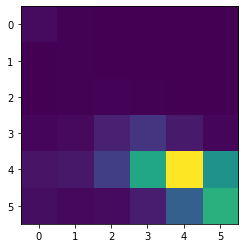

In [13]:
%%time
#pipe = Pipeline([('naive_bayes', MultinomialNB())])

from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       #('naive_bayes', MultinomialNB()) ])
                      ('classifier', RandomForestClassifier())])
                     
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipe.fit(X_train, list(y_train))


y_pred = pipe.predict(X_val)
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))
plt.imshow(confusion_matrix(y_pred, y_val))

/data/acajupyter/anaconda3/envs/server1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


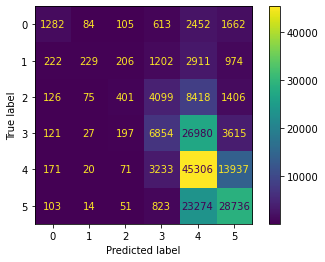

In [14]:
#Attmpt 2 - RandomForest
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

[[  865   302   417   685   975   856]
 [  167   286   412   628   731   601]
 [  377   618  1524  2715  3257  2201]
 [ 1257  1641  4637 12229 16805 11223]
 [ 1835  1809  5171 15010 26903 21220]
 [ 1697  1088  2364  6527 14067 16900]]
0.32615
CPU times: user 1h 36min 48s, sys: 17min 21s, total: 1h 54min 9s
Wall time: 1h 54min 53s


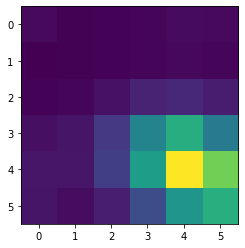

In [19]:
%%time
#attmpt 3 - SVC, knn = KNeighborsClassifier()

#pipe = Pipeline([('naive_bayes', MultinomialNB())])

from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       #('naive_bayes', MultinomialNB()) ])
                      ('classifier', KNeighborsClassifier())])
                     
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipe.fit(X_train, list(y_train))


y_pred = pipe.predict(X_val)
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))
plt.imshow(confusion_matrix(y_pred, y_val))

In [ ]:
#Attmpt 3 - Kneighbors
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

/data/acajupyter/anaconda3/envs/server1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


In [1]:
%%time
#attmpt 1 

#pipe = Pipeline([('naive_bayes', MultinomialNB())])

from sklearn.neighbors import KNeighborsClassifier
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('naive_bayes', MultinomialNB()) ])
               
                     
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.transform(y_val)

pipe.fit(X_train, list(y_train))


y_pred = pipe.predict(X_val)
print(confusion_matrix(y_pred, y_val))
print(accuracy_score(y_pred, y_val))
plt.imshow(confusion_matrix(y_pred, y_val))

NameError: name 'Pipeline' is not defined

/data/acajupyter/anaconda3/envs/server1/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


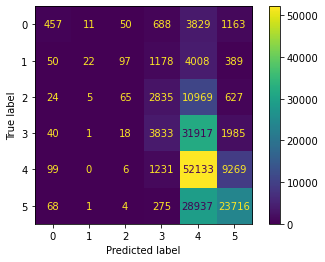

In [12]:
#Attmpt 1 - NB
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
plot_confusion_matrix(pipe, X_val, y_val)  
plt.show()

In [22]:
df_test.to_csv('submission.csv',columns = ['review_id', 'rating'],
               header = ['review_id', 'rating'], index = False)

In [23]:
df_sample = df.sample(frac = 0.3)
df_sample['rating'].value_counts()

4    93780
5    79566
3    56794
2    22002
0     9214
1     8644
Name: rating, dtype: int64